## Introduction to Semantic Chunking
Text chunking is an essential step in Retrieval-Augmented Generation (RAG), where large text bodies are divided into meaningful segments to improve retrieval accuracy.
Unlike fixed-length chunking, semantic chunking splits text based on the content similarity between sentences.

01部分我感觉用的是fixed-length chunking

### Breakpoint Methods:
- **Percentile**: Finds the Xth percentile of all similarity differences and splits chunks where the drop is greater than this value.
- **Standard Deviation**: Splits where similarity drops more than X standard deviations below the mean.
- **Interquartile Range (IQR)**: Uses the interquartile distance (Q3 - Q1) to determine split points.

This notebook implements semantic chunking **using the percentile method** and evaluates its performance on a sample text.

## Setting Up the Environment
We begin by importing necessary libraries.

In [22]:
import fitz
import os
import numpy as np
import json
from openai import OpenAI
import matplotlib.pyplot as plt

## Extracting Text from a PDF File
To implement RAG, we first need a source of textual data. In this case, we extract text from a PDF file using the PyMuPDF library.

In [2]:
def extract_text_from_pdf(pdf_path):
    """
    Extracts text from a PDF file.

    Args:
    pdf_path (str): Path to the PDF file.

    Returns:
    str: Extracted text from the PDF.
    """
    # Open the PDF file
    mypdf = fitz.open(pdf_path)
    all_text = ""  # Initialize an empty string to store the extracted text
    
    # Iterate through each page in the PDF
    for page in mypdf:
        # Extract text from the current page and add spacing
        all_text += page.get_text("text") + " "

    # Return the extracted text, stripped of leading/trailing whitespace
    return all_text.strip()

# Define the path to the PDF file
pdf_path = "data/AI_Information.pdf"

# Extract text from the PDF file
extracted_text = extract_text_from_pdf(pdf_path)

# Print the first 500 characters of the extracted text
print(extracted_text[:500])

Understanding Artificial Intelligence 
Chapter 1: Introduction to Artificial Intelligence 
Artificial intelligence (AI) refers to the ability of a digital computer or computer-controlled robot 
to perform tasks commonly associated with intelligent beings. The term is frequently applied to 
the project of developing systems endowed with the intellectual processes characteristic of 
humans, such as the ability to reason, discover meaning, generalize, or learn from past 
experience. Over the past f


## Setting Up the OpenAI API Client
We initialize the OpenAI client to generate embeddings and responses.

In [3]:
# Initialize the OpenAI client with the base URL and API key
client = OpenAI(
    base_url="https://api.studio.nebius.com/v1/",
    api_key=os.getenv("OPENAI_API_KEY")  # Retrieve the API key from environment variables
)

## Creating Sentence-Level Embeddings
We split text into sentences and generate embeddings.

怎么感觉主要的不同来自于 分句方式? split()

先为每一个sentence计算出一个embedding

In [4]:
def get_embedding(text, model="BAAI/bge-en-icl"):
    """
    Creates an embedding for the given text using OpenAI.

    Args:
    text (str): Input text.
    model (str): Embedding model name.

    Returns:
    np.ndarray: The embedding vector.
    """
    response = client.embeddings.create(model=model, input=text)
    return np.array(response.data[0].embedding)

# Splitting text into sentences (basic split)

sentences = extracted_text.split(". ")

# Generate embeddings for each sentence
embeddings = [get_embedding(sentence) for sentence in sentences]
print(len(embeddings))
# print(f"Generated {len(embeddings)} sentence embeddings.")

257


## Calculating Similarity Differences
We compute cosine similarity between consecutive sentences.

接着计算两个分句embeddingg间的similarity

In [6]:
def cosine_similarity(vec1, vec2):
    """
    Computes cosine similarity between two vectors.

    Args:
    vec1 (np.ndarray): First vector.
    vec2 (np.ndarray): Second vector.

    Returns:
    float: Cosine similarity.
    """
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

# Compute similarity between consecutive sentences
similarities = [cosine_similarity(embeddings[i], embeddings[i + 1]) for i in range(len(embeddings) - 1)]
print(similarities)

[0.7911202045667978, 0.749419649050181, 0.7833608187239459, 0.8158772334927578, 0.815337265730542, 0.7331551666346877, 0.7354201553371094, 0.6961215424663525, 0.7309646240671673, 0.8110754681305021, 0.8189023324849057, 0.6796278985163162, 0.5310714486259115, 0.8250313217973494, 0.8571214719635748, 0.8511159481041981, 0.809283803496077, 0.762848985953776, 0.820076028322866, 0.7497812999075432, 0.83645227856631, 0.74648204995284, 0.6340379679995539, 0.7166825825816612, 0.7285802373144844, 0.766511543048, 0.8303492950214135, 0.8244611289998447, 0.7877281997641047, 0.7778312320228804, 0.727498139924738, 0.8150298088896022, 0.6617348309523581, 0.8137301764959267, 0.8337190168319275, 0.7604924177958139, 0.8428366735962539, 0.8361788315888568, 0.7255912234957178, 0.8651892770881228, 0.7953741602141166, 0.8428834935807397, 0.726373985303855, 0.8189814994306606, 0.7457822588442379, 0.8077491961004885, 0.7773781944210997, 0.8647925251441901, 0.7216784804178912, 0.7910389455562659, 0.691044946557

## Implementing Semantic Chunking
We implement three different methods for finding breakpoints.

第三个主要不同的点: bp
找到哪些句子之间的相似度较低，从而决定在哪些位置“断开”文本，分成多个语义连贯的段落或区块（chunks）。



In [25]:
def compute_breakpoints(similarities, method="percentile", threshold=90):
    """
    Computes chunking breakpoints based on similarity drops.

    Args:
    similarities (List[float]): List of similarity scores between sentences.
    method (str): 'percentile', 'standard_deviation', or 'interquartile'.
    threshold (float): Threshold value (percentile for 'percentile', std devs for 'standard_deviation').

    Returns:
    List[int]: Indices where chunk splits should occur.
    """
    # Determine the threshold value based on the selected method
    if method == "percentile":
        # Calculate the Xth percentile of the similarity scores
        ## 得出在similarities这个array中, 百分之threshold的值是多少
        threshold_value = np.percentile(similarities, threshold) 
        print(threshold_value)
    elif method == "standard_deviation":
        # Calculate the mean and standard deviation of the similarity scores
        mean = np.mean(similarities)
        std_dev = np.std(similarities)
        # Set the threshold value to mean minus X standard deviations
        threshold_value = mean - (threshold * std_dev)
        print(f'mean: {mean}, std_dev: {std_dev}, threshold_value: {threshold_value}')
    elif method == "interquartile":
        # Calculate the first and third quartiles (Q1 and Q3)
        q1, q3 = np.percentile(similarities, [25, 75])
        # Set the threshold value using the IQR rule for outliers
        threshold_value = q1 - 1.5 * (q3 - q1)
        print(threshold_value)
    else:
        # Raise an error if an invalid method is provided
        raise ValueError("Invalid method. Choose 'percentile', 'standard_deviation', or 'interquartile'.")

    # Identify indices where similarity drops below the threshold value
    return [i for i, sim in enumerate(similarities) if sim < threshold_value], threshold_value


In [26]:
# Compute breakpoints using the percentile method with a threshold of 90 太高了
# 试试50/25, 意思是把相似度中排名最低的50%或者25%当作‘语意断裂’
breakpoints1 = compute_breakpoints(similarities, method="percentile", threshold=90)
print("Break Points in the Percentile way:", breakpoints1)

## load the plot of the similarities distribution
plt.plot(similarities)
plt.axhline(np.percentile(similarities, 90), color='red', linestyle='--', label='threshold')
plt.title("Sentence Similarities")
plt.xlabel("Sentence Index")
plt.ylabel("Similarity")
plt.legend()
plt.show()


0.6008813250144933
Break Points in the interquartile way:
 [12, 79, 182]


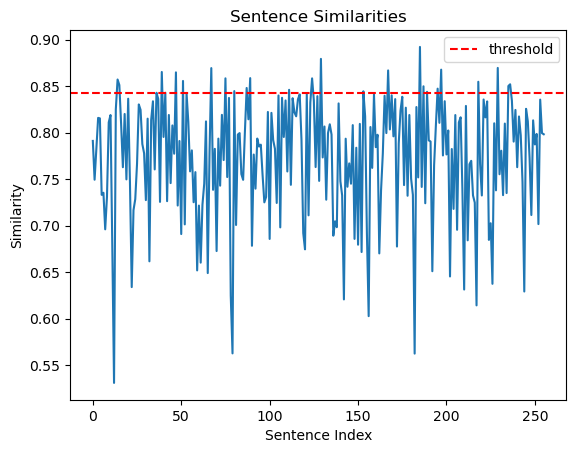

In [10]:
# breakpoints2 = compute_breakpoints(similarities, method='standard_deviation', threshold=1)
# print("Break Points in the standard_deviation way:\n", breakpoints2)


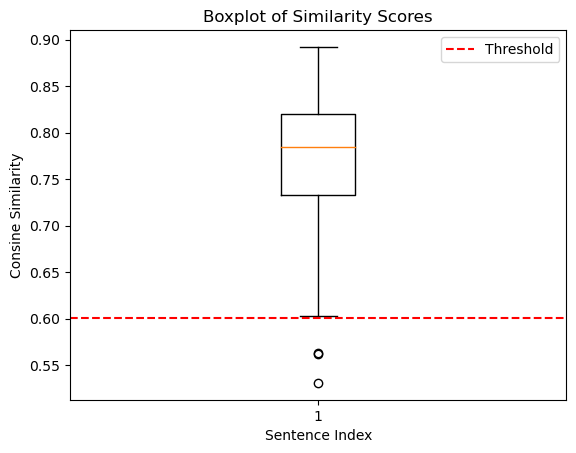

In [27]:
breakpoints3, threshold_value = compute_breakpoints(similarities, method='interquartile', threshold=1)
print("Break Points in the interquartile way:\n", breakpoints3)

plt.boxplot(similarities, vert=True)
plt.axhline(threshold_value, color="red", linestyle='--', label="Threshold")
plt.title("Boxplot of Similarity Scores")
plt.xlabel("Sentence Index")
plt.ylabel("Consine Similarity")
plt.legend()
plt.show()

## Splitting Text into Semantic Chunks
We split the text based on computed breakpoints.

第四个不同点: 根据bp来切分, 通过前面几个步骤得到了bp(idx), 这一步直接读取index

In [ ]:
def split_into_chunks(sentences, breakpoints):
    """
    Splits sentences into semantic chunks.

    Args:
    sentences (List[str]): List of sentences.
    breakpoints (List[int]): Indices where chunking should occur.

    Returns:
    List[str]: List of text chunks.
    """
    chunks = []  # Initialize an empty list to store the chunks
    start = 0  # Initialize the start index

    # Iterate through each breakpoint to create chunks
    for bp in breakpoints:
        # Append the chunk of sentences from start to the current breakpoint
        chunks.append(". ".join(sentences[start:bp + 1]) + ".")
        start = bp + 1  # Update the start index to the next sentence after the breakpoint

    # Append the remaining sentences as the last chunk
    chunks.append(". ".join(sentences[start:]))
    return chunks  # Return the list of chunks

# Create chunks using the split_into_chunks function
text_chunks = split_into_chunks(sentences, breakpoints1)

# Print the number of chunks created
print(f"Number of semantic chunks: {len(text_chunks)}")

# Print the first chunk to verify the result
print("\nFirst text chunk:")
print(text_chunks[0])


## Creating Embeddings for Semantic Chunks
We create embeddings for each chunk for later retrieval.

In [ ]:
def create_embeddings(text_chunks):
    """
    Creates embeddings for each text chunk.

    Args:
    text_chunks (List[str]): List of text chunks.

    Returns:
    List[np.ndarray]: List of embedding vectors.
    """
    # Generate embeddings for each text chunk using the get_embedding function
    return [get_embedding(chunk) for chunk in text_chunks]

# Create chunk embeddings using the create_embeddings function
chunk_embeddings = create_embeddings(text_chunks)

## Performing Semantic Search
We implement cosine similarity to retrieve the most relevant chunks.

In [ ]:
def semantic_search(query, text_chunks, chunk_embeddings, k=5):
    """
    Finds the most relevant text chunks for a query.

    Args:
    query (str): Search query.
    text_chunks (List[str]): List of text chunks.
    chunk_embeddings (List[np.ndarray]): List of chunk embeddings.
    k (int): Number of top results to return.

    Returns:
    List[str]: Top-k relevant chunks.
    """
    # Generate an embedding for the query
    query_embedding = get_embedding(query)
    
    # Calculate cosine similarity between the query embedding and each chunk embedding
    similarities = [cosine_similarity(query_embedding, emb) for emb in chunk_embeddings]
    
    # Get the indices of the top-k most similar chunks
    top_indices = np.argsort(similarities)[-k:][::-1]
    
    # Return the top-k most relevant text chunks
    return [text_chunks[i] for i in top_indices]

In [ ]:
# Load the validation data from a JSON file
with open('data/val.json') as f:
    data = json.load(f)

# Extract the first query from the validation data
query = data[0]['question']

# Get top 2 relevant chunks
top_chunks = semantic_search(query, text_chunks, chunk_embeddings, k=2)

# Print the query
print(f"Query: {query}")

# Print the top 2 most relevant text chunks
for i, chunk in enumerate(top_chunks):
    print(f"Context {i+1}:\n{chunk}\n{'='*40}")

## Generating a Response Based on Retrieved Chunks

In [ ]:
# Define the system prompt for the AI assistant
system_prompt = "You are an AI assistant that strictly answers based on the given context. If the answer cannot be derived directly from the provided context, respond with: 'I do not have enough information to answer that.'"

def generate_response(system_prompt, user_message, model="meta-llama/Llama-3.2-3B-Instruct"):
    """
    Generates a response from the AI model based on the system prompt and user message.

    Args:
    system_prompt (str): The system prompt to guide the AI's behavior.
    user_message (str): The user's message or query.
    model (str): The model to be used for generating the response. Default is "meta-llama/Llama-2-7B-chat-hf".

    Returns:
    dict: The response from the AI model.
    """
    response = client.chat.completions.create(
        model=model,
        temperature=0,
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_message}
        ]
    )
    return response

# Create the user prompt based on the top chunks
user_prompt = "\n".join([f"Context {i + 1}:\n{chunk}\n=====================================\n" for i, chunk in enumerate(top_chunks)])
user_prompt = f"{user_prompt}\nQuestion: {query}"

# Generate AI response
ai_response = generate_response(system_prompt, user_prompt)

## Evaluating the AI Response
We compare the AI response with the expected answer and assign a score.

In [ ]:
# Define the system prompt for the evaluation system
evaluate_system_prompt = "You are an intelligent evaluation system tasked with assessing the AI assistant's responses. If the AI assistant's response is very close to the true response, assign a score of 1. If the response is incorrect or unsatisfactory in relation to the true response, assign a score of 0. If the response is partially aligned with the true response, assign a score of 0.5."

# Create the evaluation prompt by combining the user query, AI response, true response, and evaluation system prompt
evaluation_prompt = f"User Query: {query}\nAI Response:\n{ai_response.choices[0].message.content}\nTrue Response: {data[0]['ideal_answer']}\n{evaluate_system_prompt}"

# Generate the evaluation response using the evaluation system prompt and evaluation prompt
evaluation_response = generate_response(evaluate_system_prompt, evaluation_prompt)

# Print the evaluation response
print(evaluation_response.choices[0].message.content)